# Topic Modeling with BERT

In [2]:
!pip install hdbscan
!pip install sentence_transformers
!pip install  tqdm

     |████████████████████████████████| 4.7MB 4.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2301846 sha256=cac6e0ff507e34cd9bd4caaa52f314d52ea34585ac00f404ac12de80c11fc300
  Stored in directory: /root/.cache/pip/wheels/82/38/41/372f034d8abd271ef7787a681e0a47fc05d472683a7eb088ed
Successfully built hdbscan
     |████████████████████████████████| 61kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 13.4MB/s 
     |████████████████████████████████| 3.0MB 33.2MB/s 
     |████████████████████████████████| 890kB 41.4MB/s 
     |████████████████████████████████| 1.1MB 36.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.7.2-cp36-none-any.whl size=91190 sha256=4226de79e164a00371371e5fdfb42f222b2f364714867b4806ddc930336538d9
  Stored in directory: /root/.cache/pip/wheels/4b/8f/23/7f

In [3]:
import numpy as np
import pandas as pd

import umap
import hdbscan
from sentence_transformers import SentenceTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt


def c_tf_idf(documents, m, ngram_range=(1, 1)):
    """ Calculate a class-based TF-IDF where m is the number of total documents. """
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

## Load data
CFPB Mortgage complaints 

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
complain_data = pd.read_excel(r'/content/drive/My Drive/CFPB LDA/CFPB_text_vs_cnsd_text_20201013_08_05_41.xlsx')
data = complain_data['Modified_text']

In [ ]:
print(complain_data.info())
print(data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11780 entries, 0 to 11779
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     11780 non-null  int64 
 1   Complaint_ID   11780 non-null  int64 
 2   Complain_text  11780 non-null  object
 3   Modified_text  11779 non-null  object
dtypes: int64(2), object(2)
memory usage: 368.2+ KB
None
0        qualify the dream program payment payment unti...
1        apply modification tell by my previous lender ...
2        my mortgage interest rate and payment with req...
3        apply mortgage loan with at the end receive pr...
4        have home equity loan and convert the home equ...
                               ...                        
11775    start modification with my mortgage company th...
11776    my problem with my lender so compile refinance...
11777    foreclose home base reverse mortgage and the b...
11778    at we think refinance our home but re

## Create embeddings
The very first step is converting the documents to numerical data. There are many methods that can be applied, but since we are modeling topics with **BERT** that is what we are going to be using.

There are many pre-trained models that you can use for a large amount of languages [here](https://www.sbert.net/docs/pretrained_models.html). Simply plug-in the name instead of *distilbert-base-nli-mean-tokens*. 

In [40]:
%%time
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)


CPU times: user 44.6 s, sys: 407 ms, total: 45.1 s
Wall time: 45.1 s


## Reduce dimensionality
We use **UMAP** to reduce the dimensionality of the embeddings created above. It is important that we keep a little bit of dimensionality as that allows the reduced embeddings to contain more structure to improve clustering at a later stage. 

You can play around with the **number of components** (dimensionality to reduce to) and the **number of neighbors** (the nearby points to look at). 

In [41]:
%%time
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=5,
                            min_dist=0.0,
                            metric='cosine',
                            random_state=42).fit_transform(embeddings)

CPU times: user 27.6 s, sys: 333 ms, total: 27.9 s
Wall time: 27.6 s


## Cluster documents
Since **UMAP** keeps some of the original high-embedded structure, it makes sense to use **HDBSCAN** to find highly-densed clusters. The metric is euclidean since it does not suffer from high-dimensionality and the **minimum cluster size** allows you to decrease the number of topics found and increase the topic sizes. 

In [42]:
%%time
cluster = hdbscan.HDBSCAN(min_cluster_size=30,
                          metric='euclidean',
                          cluster_selection_method='eom', 
                          prediction_data=True).fit(umap_embeddings)

CPU times: user 1.03 s, sys: 978 µs, total: 1.03 s
Wall time: 1.03 s


## Visualize Clusters
We can visualize the resulting cluster by embedding the data into **2d-space** using **UMAP** and using matplotlib to color the clusters. Some clusters are difficult to spot as there may be > 50 topics generated. 

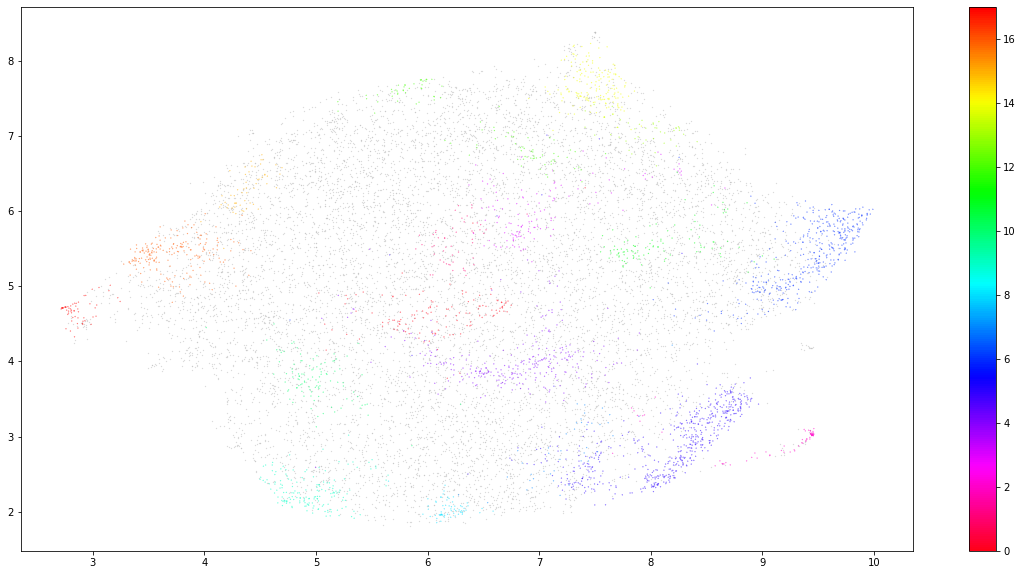

In [43]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()
# plt.savefig("result1.png", dpi = 300)

## Prepare results
For easier selection, we put the results in a pandas dataframe. Then, *docs_per_label* is created in which all documents within a single cluster are joined. 

In [44]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
#docs_df['Doc_ID'] = range(len(docs_df))
#docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

TypeError: ignored

In [48]:
docs_df.groupby(['Topic'])

## Calculate word importance per topic
Calculate the importance of words  in a topic compared to all other topics by considering all documents in a topic to be a single document instead before applying **TF-IDF**. Then, we simply extract the words with the highest values in each cluster as a representative of a topic. 

In [ ]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m = len(data))

In [ ]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

In [ ]:
print(topic_sizes)

In [ ]:
top_n_words[28]

## Topic Reduction

In [ ]:
for i in tqdm(range(20)):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

In [ ]:
print(topic_sizes)